<a href="https://colab.research.google.com/github/RSNA/AI-Deep-Learning-Lab/blob/master/IntrotoDeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Deep Learning
# RSNA AI Deep Learning Lab

###by: Bradley J Erickson, MD PhD
*Copyright 2019


In this session we will:
1) download and unzip 6 different classes of radiological images (CT Head, CT Chest, CT Abdomen, MRBrain, MRBreast, and Chest X-Ray). 
2) We will use a Convolutional Neural Network (CNN) pretrained on routine photographic images and using the ResNet-34 architecture to classify each of the 3 types of images
3) We will review the performance of the system, note the 'worst' errors, and consider how we might improve performance
4) Build a network from scratch using the tensorflow framework and do the same classification problem
5) Train a CNN to de-noise low dose CT images  (Starts at Cell 20)


In [0]:
#Cell 1
# first, need to install and then import the fastai library
!pip3 install fastai
from fastai.vision import *

In [0]:
#Cell 2
# clean out any old data just to be sure, such as if re-running cells
!rm -rf MagiciansCorner
!rm -rf images
!rm -rf sample_data . # Google supplies this but not needed
import os

!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1mqgBKTB0MtGf8Fhc8HaedJyiD8yMoXOh' -O ./MedNIST.zip

!mkdir images
!cd images; unzip -q "../MedNIST.zip" 
!rm -rf MagiciansCorner
# get rid of MAC garbage stuff
!rm -rf ./images/__MACOSX
!ls images


rm: refusing to remove '.' or '..' directory: skipping '.'
--2019-11-21 17:30:41--  https://docs.google.com/uc?export=download&id=1mqgBKTB0MtGf8Fhc8HaedJyiD8yMoXOh
Resolving docs.google.com (docs.google.com)... 74.125.133.100, 74.125.133.139, 74.125.133.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.133.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qfafkhb48aqksmb5sk3h834sm1a6k44t/1574352000000/16160187475894979440/*/1mqgBKTB0MtGf8Fhc8HaedJyiD8yMoXOh?e=download [following]
--2019-11-21 17:30:54--  https://doc-0s-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qfafkhb48aqksmb5sk3h834sm1a6k44t/1574352000000/16160187475894979440/*/1mqgBKTB0MtGf8Fhc8HaedJyiD8yMoXOh?e=download
Resolving doc-0s-60-docs.googleusercontent.com (doc-0s-60-docs.googleusercontent.com)... 64.233.167.132, 2a00:1450:400c:c0a::84
Conn

In [0]:
#Cell 3
classes_dir = "./images"
flist = os.listdir(classes_dir)
print (flist)

['CXR', 'MRBreast', 'CTChest', 'MRBrain', 'CTAbd', 'CTHead']


### We have already gone through and converted the DICOM images to JPEG (grayscale) images, and also sized so they are all 64x64 (if we kept CXRs as some size other than 64x64, it would cause the CNN to fail--all image MUST be the same size. The next article will explain more about this.



## View data

In [0]:
#Cell 4
np.random.seed(42)
tfms = get_transforms(flip_vert=False,                # flip vertical and horizontal
                      max_rotate=20.0,                # rotation between -30° and 30°
                      max_zoom=1.2)                   # zoom between 1 and 1.2
# Uncomment the line below to turn off augmentation (sets the transformations to nothing. Note that you will still see many images, but they are all the same
# tfms=[[],[]]

data = ImageDataBunch.from_folder(classes_dir, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=64, num_workers=4).normalize(imagenet_stats)
data.classes
data.classes, data.c, len(data.train_ds), len(data.valid_ds)


(['CTAbd', 'CTChest', 'CTHead', 'CXR', 'MRBrain', 'MRBreast'], 6, 1440, 360)

Good! Let's take a look at some of our pictures then.

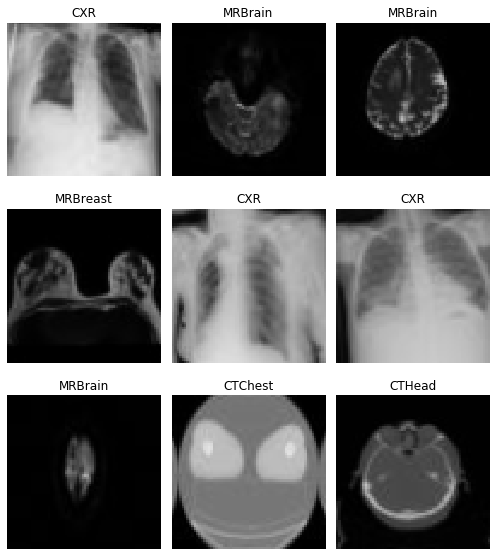

In [0]:
#Cell 5
data.show_batch(rows=3, figsize=(7,8))

def get_img(img_url): return open_image(img_url)

# Function that displays many transformations of an image
def plots_of_one_image(img_url, tfms, rows=1, cols=3, width=15, height=5, **kwargs):
    img = get_img(img_url)
    [img.apply_tfms(tfms, **kwargs).show(ax=ax)
         for i,ax in enumerate(plt.subplots(rows,cols,figsize=(width,height))[1].flatten())]


## Train model

In [0]:
#Cell 6
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
#learn = cnn_learner(data, models.resnet50, metrics=error_rate)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 25.0MB/s]


In [0]:
#Cell 7
learn.fit_one_cycle(3)
learn.save("MedNIST-34-1")

epoch,train_loss,valid_loss,error_rate,time
0,1.012946,0.343757,0.113889,00:05
1,0.490720,0.109170,0.041667,00:04
2,0.298485,0.051706,0.013889,00:04


#Evaluation
* During the training process, the data is split into 3 parts: training,  validation and test. The training data is used to adjust the weights. The GPU does not have enough RAM to store the entire training set of images, so it is split into 'batches'. When all of the images have been used once for training, then an 'epoch' has passed. Once trained for that epoch, it evaluates how well it has learned using the 'validation' data set. The performance on the training set is the train_loss and the performance on the validation set is the valid_loss, and the error_rate is also the percentage of cases wrong in the validation set.
* It is common practice that after 'acceptable' performance is achieved on the vclidation set, that the system is tested on the 'test' data, and that is what is considered the 'real' performance.

* Note that some use 'test' for what is called validation here, and vice versa.

* But sometimes the overall error rate doesn't really tell the story. We might care more about false positives than false negatives, and vica versa. Looking at early results can provide valuable insight into the training process, and how to improve results.

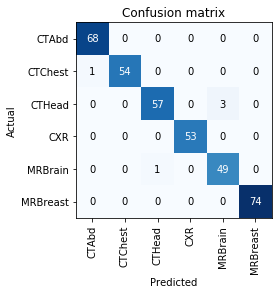

In [0]:
#Cell 8
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Looking closer
* The confusion matrix shows the classes that are confused.
* Lets look a little closer at those. FastAI has a nice function that can show you the cases the it did the worst on. Think about that--there are 'errors' but what are the worst errors?
* Well, the class assigned to an image is the class that gets the highest score. So the 'worst' would be those where the score for the correct class was lowest. The function 'plot_top_losses' will show the predicted class, the real class, and the score, as well as the image for the N 
(in our case, 9) worst scored cases.
* The second line of code in the cell shows another nice feature of FastAI: to get documentation on any function, just type 'doc(function)' and it will print the documentation for that function. AND it also has a link you can click to then see teh actual source code that implements that function.

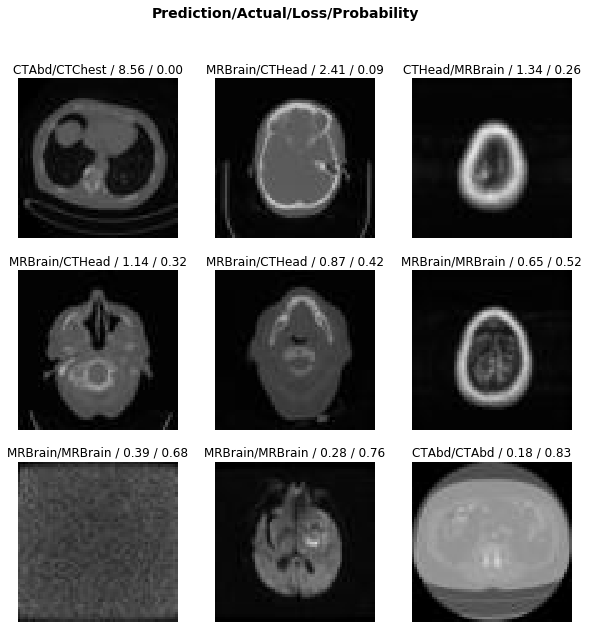

In [0]:
#Cell 9
interp.plot_top_losses(9, figsize=(10,10))
#doc(interp.plot_top_losses)

# What do we see?
* Most of the errant classes are slices that contain BOTH lung and abdomen. 
* This is an important point: Data preparation and curation is critical to getting good results
* We can argue about how to handle these cases. The correct answer probably depends on your use case. The point is that without seeing these error cases, fyou might never know what was going wrong...


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


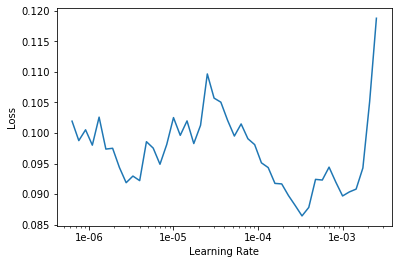

In [0]:
#Cell 10
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()


# Improving Performance:
* We 'cheated' by starting with a network that was already trained on more than 1,000,000 images. That means the system really only had to learn the specific features of these body parts, but the lower level features like edges and lines were already 'known' to be important to the network.
* On the other hand, the 'pretrained' network was trained on photographic images, which are color, not gray scale, and had a matrix size other than 64x64. 
* At the end of this notebook we create a network from scratch and also have random values for all the weights, forcing the network to 'learn it all'. This will generally take a longer time, and may also require more data to prevent over-fitting, since all weights are free to learn, rather than just a few. 

In [0]:
#Cell 11
learn.fit_one_cycle(5, max_lr=slice(3e-6,3e-5))
learn.save("Unfreeze-34-1")

epoch,train_loss,valid_loss,error_rate,time
0,0.108248,0.045984,0.011111,00:05
1,0.090681,0.036208,0.005556,00:05
2,0.070810,0.036745,0.011111,00:05
3,0.059409,0.036924,0.011111,00:05
4,0.049734,0.036761,0.008333,00:05


# Image Classifier in Tensorflow
Another framework for deep learning that is probably the most popular is called tensorflow. Version 2 was recently released, and this release is much easier to develop with, at least for many.
Here we create a rather simple image classifier which can serve as a good starting point. We will use the same data as for the FastAI example, and will also do image augmentation of similar form.
An important difference is that we will explicitly use a data generator, which means that the system will stream examples from disk to the algorithm. The advantage is that this enables us to have training sets much larger than what will fit in the memory of our computer. 

In [0]:
# Cell 12
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt


TensorFlow 2.x selected.


In [0]:
# Cell 13
import shutil
!rm -rf './images/models'
!rm -rf './images/train'
!rm -rf './images/val'
!rm -rf './tf'

# Here we will explicitly separate the training and validation data
classes_dir = "./images"
class_list = os.listdir(classes_dir)
num_classes = len(class_list)

#print (flist)
try:
    os.mkdir('./tf')
    os.mkdir("./tf/train")
    os.mkdir("./tf/val")
except:
    pass

train_dir = './tf/train'
val_dir = './tf/val'

for cls in class_list:
    tot_files = os.listdir(os.path.join(classes_dir, cls))
    num_trn_files = int(len(tot_files) * 0.8)
    trn_files = tot_files[0:num_trn_files]
    val_files = tot_files[num_trn_files:-1]
    src_dir = os.path.join (classes_dir, cls)
    target_dir = os.path.join(train_dir, cls)
    try:
        os.mkdir(target_dir)
    except:
        pass
    for f in trn_files:
        shutil.copyfile(os.path.join(src_dir, f), os.path.join(target_dir, f))

    target_dir = os.path.join(val_dir, cls)
    try:
        os.mkdir(target_dir)
    except:
        pass
    for f in val_files:
        shutil.copyfile(os.path.join(src_dir, f), os.path.join(target_dir, f))

image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=10,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.1
                    )
batch_size = 64
IMG_SHAPE = 64

train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )
# also use generator for validation data
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')


Found 1437 images belonging to 6 classes.
Found 357 images belonging to 6 classes.


# Create the CNN
In the cell below, we create a convolutional neural network that consists of 3 convolution blocks. Each convolutional block contains a Conv2D layer followed by a max pool layer. The first convolutional block should have 16 filters, the second one should have 32 filters, and the third one should have 64 filters. All convolutional filters should be 3 x 3. All max pool layers should have a pool_size of (2, 2).

After the 3 convolutional blocks you should have a flatten layer followed by a fully connected layer with 512 units. The CNN should output class probabilities based on 3 classes which is done by the softmax activation function. All other layers should use a relu activation function. You should also add Dropout layers with a probability of 20%, where appropriate.


In [0]:
# Cell 14
model = Sequential()

model.add(Conv2D(16, 5, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))


If you want to load a pre-crated model, you can do that
See code in teh cell below. We will give it a different
model name, and not use it. This is just here in case you want to try


In [0]:
# Cell 15
base_res = tf.keras.applications.ResNet50V2(weights= None, include_top=False, 
                                          input_shape= (IMG_SHAPE,IMG_SHAPE,3))
x = base_res.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
resnet_model = tf.keras.Model(inputs = base_res.input, outputs = predictions)

# Compile the Model
In the cell below, compile your model using the ADAM optimizer, the sparse cross entropy function as a loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so make sure you also pass the metrics argument.


In [0]:
# Cell 16

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Train the Model
Here we actually do the work of having the generator feed the data to the model and train it.


In [0]:
# Cell 17
from tensorflow.keras.callbacks import EarlyStopping

epochs = 10
checkpoint_path = "training_1/tf2.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    callbacks=[cp_callback],
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
    )


Epoch 1/10
22/23 [===========================>..] - ETA: 0s - loss: 1.0619 - accuracy: 0.5557
Epoch 00001: saving model to training_1/tf2.ckpt
23/23 [==============================] - 4s 183ms/step - loss: 1.0424 - accuracy: 0.5637 - val_loss: 0.5125 - val_accuracy: 0.8880
Epoch 2/10
22/23 [===========================>..] - ETA: 0s - loss: 0.5526 - accuracy: 0.7516
Epoch 00002: saving model to training_1/tf2.ckpt
23/23 [==============================] - 3s 149ms/step - loss: 0.5473 - accuracy: 0.7550 - val_loss: 0.2608 - val_accuracy: 0.9356
Epoch 3/10
22/23 [===========================>..] - ETA: 0s - loss: 0.3968 - accuracy: 0.8478
Epoch 00003: saving model to training_1/tf2.ckpt
23/23 [==============================] - 3s 150ms/step - loss: 0.3930 - accuracy: 0.8504 - val_loss: 0.2043 - val_accuracy: 0.9216
Epoch 4/10
22/23 [===========================>..] - ETA: 0s - loss: 0.2879 - accuracy: 0.9009
Epoch 00004: saving model to training_1/tf2.ckpt
23/23 [============================

# Evaluate performance
Here we see how well the model performed, including seeing performance on the training and validation sets


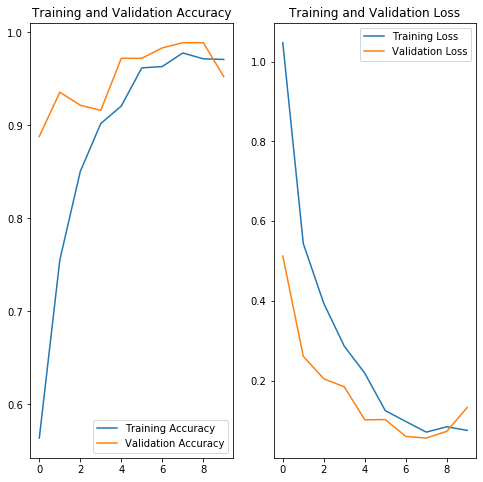

In [0]:
# Cell 18

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#  Convolutional Neural Network Denoising: Computed Tomography
*Authors: Nathan R. Huber and Andrew D. Missert*

CT Clinical Innovation Center, Department of Radiology, Mayo Clinic, Rochester, MN

This tutorial demonstrates an application of a deep convolutional neural network (CNN) for reducing noise in computed tomography (CT) images. The CNN is trained to map input low dose CT (LDCT) images to output images which approximate the routine dose CT (RDCT) images. By leveraging the prior information contained in many examples of matched LDCT and RDCT images, CNN denoising can reduce noise while maintaining high levels of anatomic detail.This demo presents a simple overview of the training procedure for illustrative purposes. This is not intended to produce an optimal result. A comparison with more advanced methods is demonstrated at the end of the notebook. 

# Loading data: Training, validation, and testing
In order to train the CNN, we need many examples of LDCT and RDCT images. We must also be careful to evaluate the denoising performance on different images than those use for training. This can be done by partitioning the data into training examples, which are used to optimize the CNN parameters, validation examples, which are used to monitor the optimization process, and testing examples, which are used to check performance after optimization.

The data used in this tutorial is made available through the AAPM and Mayo Clinic Low Dose CT Grand Challenge (Medical Physics 44(10), 2017). Each training example consists of a pair of images: the input, which is a simulated 25% dose CT image, and the target, which is the corresponding full-dose CT image.

In [0]:
# Cell 20

# load data for tutorial from github

!rm -rf images_train
!rm -rf images_val
!rm -rf images_test
!rm -rf Denoising_Data

!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-ZqL_1cqWeG6LsRAB0TwiddW8TgQ-q70' -O ./Denoising_Data.zip
!unzip -q "./Denoising_Data.zip"


--2019-11-21 17:33:11--  https://docs.google.com/uc?export=download&id=1-ZqL_1cqWeG6LsRAB0TwiddW8TgQ-q70
Resolving docs.google.com (docs.google.com)... 74.125.133.113, 74.125.133.139, 74.125.133.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.133.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/u54jnompaa1lju3j9n2e6louv3cddlsl/1574352000000/16160187475894979440/*/1-ZqL_1cqWeG6LsRAB0TwiddW8TgQ-q70?e=download [following]
--2019-11-21 17:33:12--  https://doc-00-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/u54jnompaa1lju3j9n2e6louv3cddlsl/1574352000000/16160187475894979440/*/1-ZqL_1cqWeG6LsRAB0TwiddW8TgQ-q70?e=download
Resolving doc-00-60-docs.googleusercontent.com (doc-00-60-docs.googleusercontent.com)... 64.233.167.132, 2a00:1450:400c:c0a::84
Connecting to doc-00-60-docs.googleusercontent.com (doc-00-60-d

In [0]:
# Cell 21

# load training data, used to update CNN weights
# 2000 30x30 image patches from 8 patients
train_input = np.load('./Denoising_Data/train_input.npy')
train_target = np.load('./Denoising_Data/train_target.npy')
# load validation data, used to monitor for overfitting
# 1000 30x30 image patches from 1 patient
val_input = np.load('./Denoising_Data/val_input.npy')
val_target = np.load('./Denoising_Data/val_target.npy')

# load testing data, used for evaluating performance
# 5 512x512 images from 1 patient
test_input = np.load('./Denoising_Data/test_input.npy')
test_target = np.load('./Denoising_Data/test_target.npy')

# Load examples images from state-of-the-art CNN denoising for CT images
test_example = np.load('./Denoising_Data/test_input_denoised.npy')


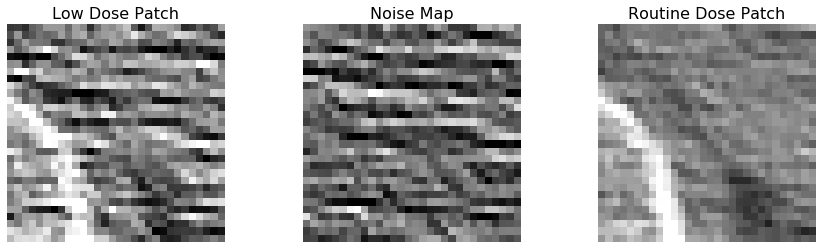

In [0]:
# Cell 22

# show some examples of training patches
nexample = 12
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title('Low Dose Patch', fontsize=16)
plt.imshow(train_input[nexample, :, :, 0], cmap='gray', vmin=-160, vmax=240)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title('Noise Map', fontsize=16)
plt.imshow(train_target[nexample, :, :, 0] - train_input[nexample, :, :, 0], cmap='gray', vmin=-160, vmax=240)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title('Routine Dose Patch', fontsize=16)
plt.imshow(train_target[nexample, :, :, 0], cmap='gray', vmin=-160, vmax=240)
plt.axis('off')
plt.show()

# Building Keras model:
CNNs are simply mathematical functions that consist of repeated convolution operations. Each convolutional layer convolves multiple filters (kernels) over the input images. The values used for each filter are free parameters that are adjusted during the training procedure. A simple non-linear activation function is also applied between the convolutional layers.Provided below is a basic model for CNN denoising containing convolutional layers and relu activation layers. Each layer operates on the output of the previous layer.

In [0]:
# Cell 23
from tensorflow.keras.layers import Activation, Input, Conv2D, Lambda
from tensorflow.keras.models import Model
# model parameters
n_layers = 5 #< total number of convolutional layers in this model
filters = 16 #< number of feature maps in each layer
kernel_size = (3, 3) #< size of convolution kernel for each layer (in pixels)
strides = (1, 1) #< number of pixels the kernel moves at each convolutional step

# for preprocessing
shift_mean = train_input.mean()
rescale = train_input.std()

# define the model
def build_model():

    # clear previous models
    tf.keras.backend.clear_session()
    
    # input tensor with arbitrary shape
    xin = Input(shape=(None, None, 1), name='input_CT_images')
    
    # normalize input
    x = Lambda(lambda x: (x - shift_mean) / rescale, name='normalize')(xin)
    
    # create the core convolutional number of layers
    for i in range(n_layers - 1):
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same')(x)
        x = Activation('relu')(x)

    # final layer has just one feature map corresponding to output image
    x = Conv2D(filters=1,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same')(x)
    
    # rescale output
    xout = Lambda(lambda x: (x * rescale) + shift_mean, name='output_CT_images')(x)
    
    # to define a model, simply specify the input and output tensors
    model = Model(inputs=xin, outputs=xout, name="CTDenoiser")
    return model
    
# build the model
model_CT = build_model()
model_CT.summary()
initial_weights = model_CT.get_weights()

Model: "CTDenoiser"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_CT_images (InputLayer) [(None, None, None, 1)]   0         
_________________________________________________________________
normalize (Lambda)           (None, None, None, 1)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 16)    160       
_________________________________________________________________
activation (Activation)      (None, None, None, 16)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 16)    2320      
_________________________________________________________________
activation_1 (Activation)    (None, None, None, 16)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 16)    2

# Optimization: Training the network
Take a moment to appreciate the number of trainable parameters listed in the model summary above. These parameters start off randomly initialized and must be optimized to perform a denoising task.For this tutorial, these parameters will be optimized with one goal in mind: to minimize the mean-squared-error (MSE) difference between the CNN output images and the low-noise target images.

In [0]:
# Cell 24
from tensorflow.keras.optimizers import Adam
# Training parameters 
epochs = 15             #< determines how many iterations through training dataset during optimization
batch_size = 512         #< number of example images used to calculate a single weight update
learning_rate = 0.0001  #< adjusts magnitude of changes to CNN weights after each batch
print (str(len(train_input)) + ' training examples')
# Setup optimzer
optimizer = Adam(lr=learning_rate)
model_CT.set_weights(initial_weights)
model_CT.compile(optimizer=optimizer, loss='mse')

# monitor progress
progress_example = 2
buffer = 128
progress_ims = []

#Train the model:
for epoch in range(epochs):
# evaluate model in current state on reserved validation data
    val_mse = model_CT.evaluate(val_input, val_target)
    test_img = model_CT.predict(test_input, batch_size=1)
    test_img = test_img[progress_example, buffer:-buffer, buffer:-buffer, 0]
    progress_ims.append(test_img)
    
    # update model using training data
    istart = 0
    while istart < (len(train_input) - batch_size):
        x = train_input[istart:istart+batch_size]
        y = train_target[istart:istart+batch_size]
        model_CT.train_on_batch(x=x, y=y)
        istart += batch_size

        
progress_ims = np.stack(progress_ims, axis=0)

print('Training phase complete.')


2250 training examples
1000/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 The CNN starts with randomly initialized parameters. During optimization, the parameters are adjusted to minimize the loss function. In order to minimize the loss function, the CNN must compute output images which resemble the corresponding RDCT images. Let's take a look at the outputs at some intermediate steps during training to see how the optimization has progressed.

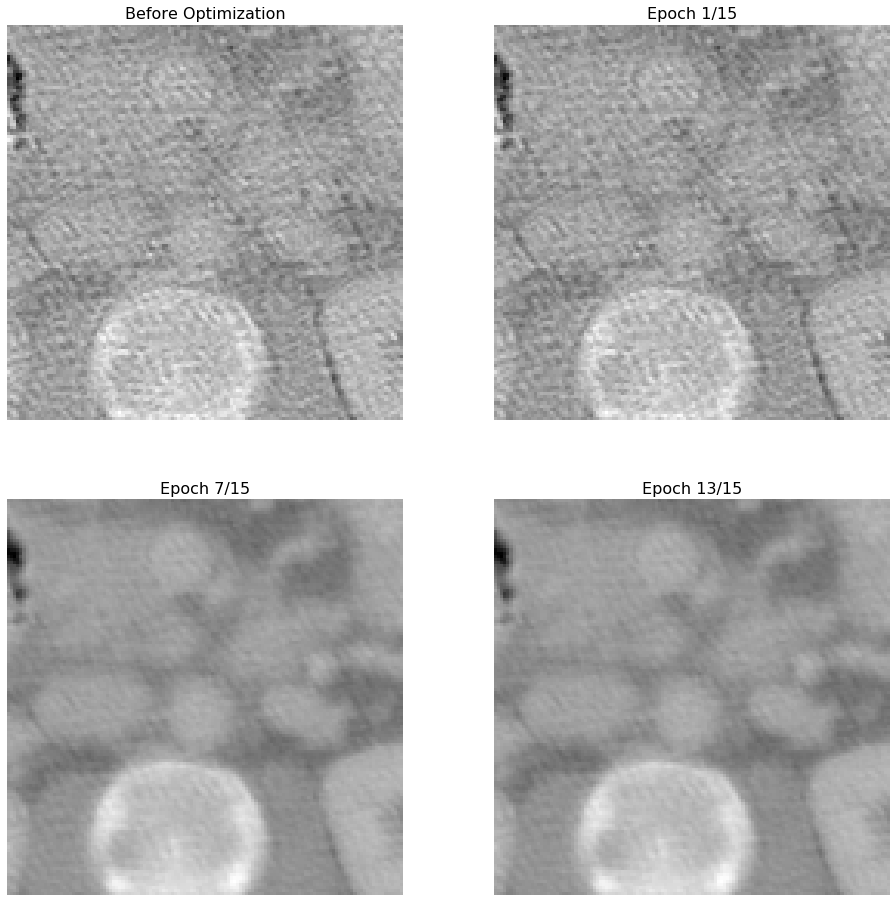

In [0]:
# Cell 25
import scipy
import matplotlib.pyplot as plt
import matplotlib.style as style
# show intermediate images at each epoch:
plt.figure(figsize=(16, 16))
window_width = 500
window_level = 0
vmin = window_level - window_width
vmax = window_level + window_width

vmin = np.min(progress_ims)
vmax = np.max(progress_ims)
middle_epoch = epochs // 2

plt.subplot(2, 2, 1)
plt.title('Before Optimization', fontsize=16)
plt.axis('off')
vmin = np.min(progress_ims[0,:,:])
vmax = np.max(progress_ims[0,:,:])
plt.imshow(progress_ims[0, :, :], cmap='gray', vmin=vmin, vmax=vmax)

plt.subplot(2, 2, 2)
plt.title('Epoch %d/%d' %(1, epochs), fontsize=16)
plt.axis('off')
vmin = np.min(progress_ims[1,:,:])
vmax = np.max(progress_ims[1,:,:])
plt.imshow(progress_ims[1, :, :], cmap='gray', vmin=vmin, vmax=vmax)

plt.subplot(2, 2, 3)
plt.title('Epoch %d/%d' %(middle_epoch, epochs), fontsize=16)
plt.axis('off')
vmin = np.min(progress_ims[epoch,:,:])
vmax = np.max(progress_ims[epoch,:,:])
plt.imshow(progress_ims[epoch, :, :], cmap='gray', vmin=vmin, vmax=vmax)

plt.subplot(2, 2, 4)
plt.title('Epoch %d/%d' %(epoch - 1, epochs), fontsize=16)
plt.axis('off')
plt.imshow(progress_ims[epoch, :, :], cmap='gray', vmin=vmin, vmax=vmax)


# Inference: Testing the network
Now that the network is fully trained, we can apply to our CNN in inference mode to the reserved testing data to check the performance. Since all CNN parameters are fixed at this point, the processing time for this phase is typically very fast.

Time to apply CNN: 0.053006070000784736 seconds per image



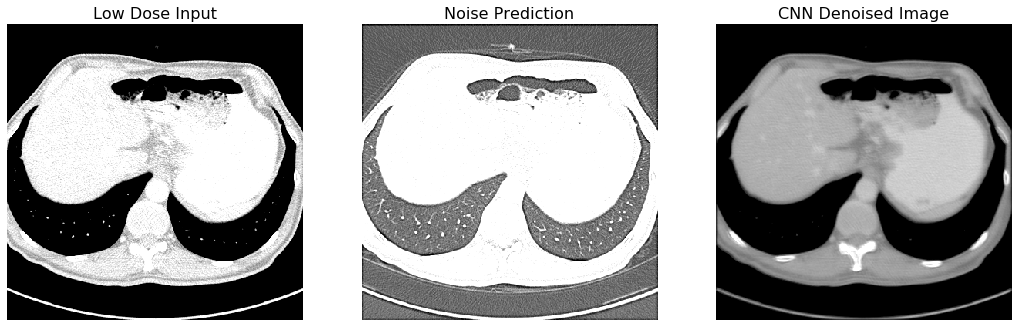

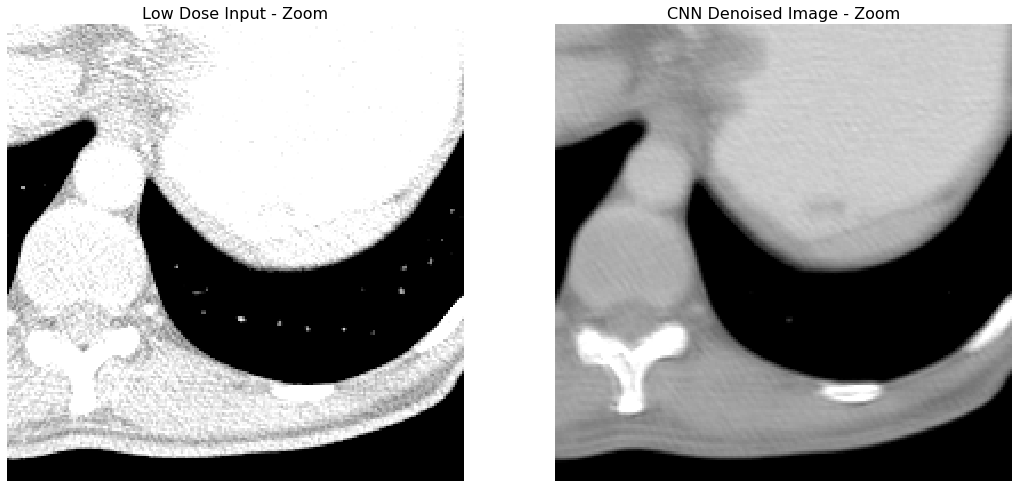

In [0]:
# Cell 26
import time

#Load full quarter dose test image and display result:
nexample = 1
start = time.time()
CNNout = model_CT.predict(test_input)
end = time.time()
print('Time to apply CNN: ' + str((end - start)/test_input.shape[0]) + ' seconds per image\n')

window_width = 200
window_level = 50


plt.figure(figsize=(18, 9))
plt.subplot(1, 3, 1)
#vmin = window_level - window_width
#vmax = window_level + window_width
plt.title('Low Dose Input', fontsize=16)
plt.imshow(test_input[nexample, :, :, 0],cmap='gray',vmin=vmin,vmax=vmax)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title('Noise Prediction', fontsize=16)
plt.imshow(test_input[nexample, :, :, 0] - CNNout[nexample, :, :, 0], cmap='gray', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title('CNN Denoised Image', fontsize=16)
plt.imshow(CNNout[nexample, :, :, 0], cmap='gray', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.show()

plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plt.title('Low Dose Input - Zoom', fontsize=16)
plt.imshow(test_input[nexample, 150:350, 150:350, 0], cmap='gray', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('CNN Denoised Image - Zoom', fontsize=16)
plt.imshow(CNNout[nexample, 150:350, 150:350, 0], cmap='gray', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.show()


# Analysis: Noise level and line profiles
Denoising performance is commonly evaluated on the basis of noise level and spatial resolution. One way to measure the noise level is to calculate root mean square error (RMSE) noise at a uniform region, such as the aorta. Resolution can be evaluated by looking at line profiles or the difference image.For comparison, we have also included some examples from a more advanced CNN-based denoising approach: CNN autotuning. This is a method for optimizing the CNN denoising performance for individual patient exams. More details can be found at the talk "Patient-Specific Noise Reduction Using a Deep Convolutional Neural Network" (SSE24-02).   The non-linearity of the CNN function means that the resolution and RMSE performance are highly context dependent. The measurements here may not apply to different input images.

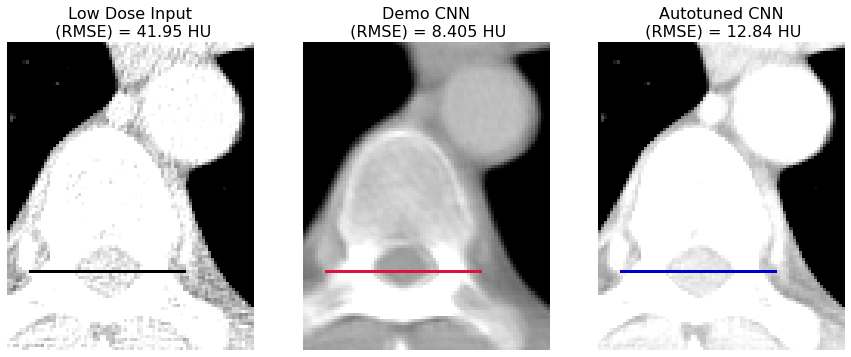

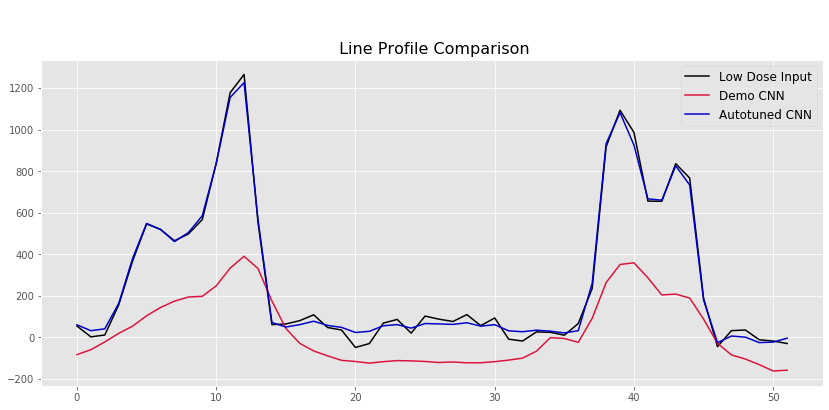

In [0]:
# Cell 27

# Standard deviation noise in approximately uniform region (aorta)
std_in = test_input[0, 219:239, 201:221, 0].std()
std_demo = CNNout[0, 219:239, 201:221, 0].std()
std_autotune = test_example[0, 219:239, 201:221, 0].std()

plt.figure(figsize=(15, 15))

plt.subplot(1, 3, 1)
plt.title('Low Dose Input\n (RMSE) = %.4g HU' % std_in, fontsize=16)
plt.imshow(test_input[0, 206:306, 151:231, 0], cmap='gray', vmin=vmin, vmax=vmax)
plt.plot([7, 57], [74, 74], 'black', lw=3)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Demo CNN\n (RMSE) = %.4g HU' % std_demo, fontsize=16)
plt.imshow(CNNout[0, 206:306, 151:231, 0], cmap='gray', vmin=vmin, vmax=vmax)
plt.plot([7, 57], [74, 74], 'crimson', lw=3)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Autotuned CNN\n (RMSE) = %.4g HU' % std_autotune, fontsize=16)
plt.imshow(test_example[0, 206:306, 151:231, 0], cmap='gray', vmin=vmin, vmax=vmax)
plt.plot([7, 57], [74, 74], 'mediumblue', lw=3)
plt.axis('off')
plt.show()

# Line profile comparison
style.use('ggplot') 
plt.figure(figsize=(14, 6))
plt.title('\n\n Line Profile Comparison', fontsize=16)
plt.plot(test_input[0, 280, 158:210, 0], label="Low Dose Input",color='black')
plt.plot(CNNout[0, 280, 158:210, 0], label="Demo CNN",color='crimson')
plt.plot(test_example[0, 280, 158:210, 0], label="Autotuned CNN",color='mediumblue')
plt.legend(fontsize=12)
plt.show()

# Comparison: Gaussian and Median Filter
To further demonstrate the benefits of deep learning for CT image denoising, we can compare these result with other basic filters. Here we have implemented a Gaussian and median filter. Notice that these basic filters are capable of producing results that are low noise but at the cost of significant resolution loss. Notice how CNN denoising was able to reduce noise while maintaining small features. Again, we provide an example from our research ("Autotuned CNN") to demonstrate the performance using more advanced methods than those found in this demo.

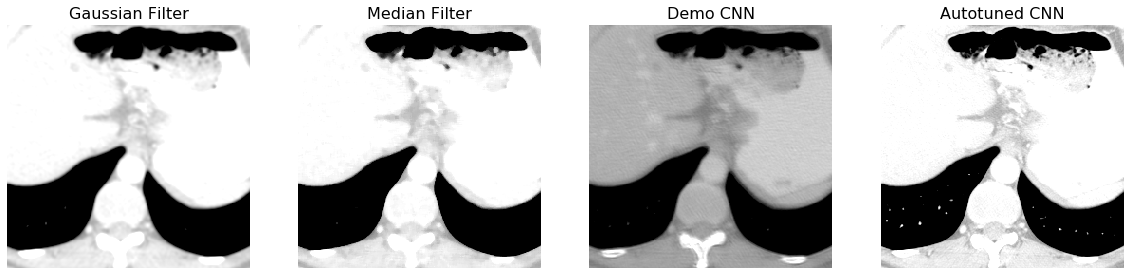

In [0]:
# Cell 28

# Visual comparison with basic filtering strategies

example_index = 1   #< change this to view a different image
frame = 64
medfilt = scipy.ndimage.median_filter(test_input[example_index, :, :, 0], size=5)
gaussfilt = scipy.ndimage.gaussian_filter(test_input[example_index, :, :, 0], sigma=1.4)

plt.figure(figsize=(20, 6))

plt.subplot(1, 4, 1)
plt.title('Gaussian Filter', fontsize=16)
plt.imshow(gaussfilt[frame:-frame, frame:-frame], cmap='gray', vmin=vmin, vmax=vmax)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title('Median Filter', fontsize=16)
plt.imshow(medfilt[frame:-frame, frame:-frame], cmap='gray', vmin=vmin, vmax=vmax)
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title('Demo CNN', fontsize=16)
plt.imshow(CNNout[example_index, frame:-frame, frame:-frame, 0], cmap='gray', vmin=vmin, vmax=vmax)
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title('Autotuned CNN', fontsize=16)
plt.imshow(test_example[example_index, frame:-frame, frame:-frame, 0], cmap='gray', vmin=vmin, vmax=vmax)
plt.axis('off')

plt.show()

I# ndividualized CNN Denoising
CNN-based noise reduction leverages prior information from the training data to distinguish between noise and anatomic background in CT images. One potential drawback of this approach is that it it may fail when applied to images that are not sufficiently similar to those used during training. One way around this issue is to fine-tune the CNN to the anatomic features and typical noise textures for individual patient exams. This can help ensure optimal performance on a case-by-case basis. 
#For more details, see the talk "Patient-Specific Noise Reduction Using a Deep Convolutional Neural Network" (SSE24-02) at RSNA this year. 
Some examples using this technique can be seen below. Notice the increased resolution of anatomic features compared to conventional CNN denoising.

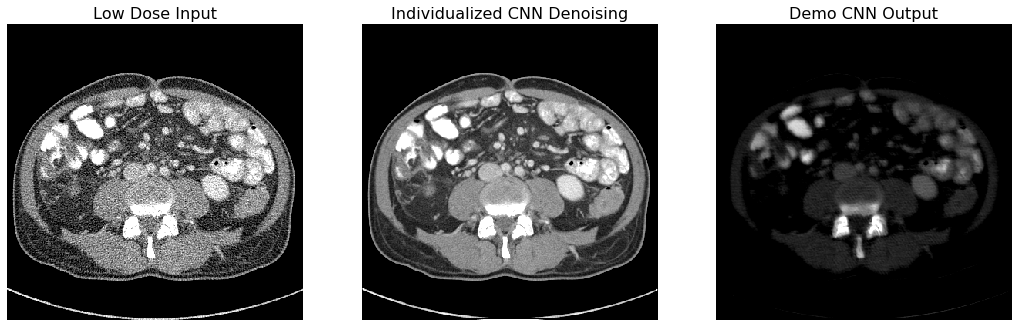

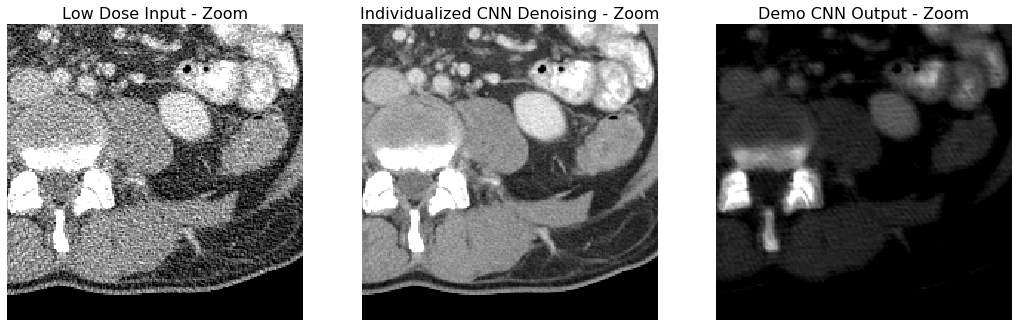

In [0]:
# Cell 29

#Load full quarter dose test image and display result:
nexample = 3  #< change this to view a different example (up to 7)

window_width = 400
window_level = 40
vmin = window_level - window_width // 2
vmax = window_level + window_width // 2

plt.figure(figsize=(18, 9))
plt.subplot(1, 3, 1)
plt.title('Low Dose Input', fontsize=16)
plt.imshow(test_input[nexample, :, :, 0],cmap='gray',vmin=vmin,vmax=vmax)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Individualized CNN Denoising", fontsize=16)
plt.imshow(test_example[nexample, :, :, 0], cmap='gray', vmin=vmin, vmax=vmax)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Demo CNN Output', fontsize=16)
plt.imshow(CNNout[nexample, :, :, 0], cmap='gray', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.show()

plt.figure(figsize=(18, 9))
plt.subplot(1, 3, 1)
plt.title('Low Dose Input - Zoom', fontsize=16)
plt.imshow(test_input[nexample, 150:350, 150:350, 0], cmap='gray', vmin=vmin, vmax=vmax)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Individualized CNN Denoising - Zoom', fontsize=16)
plt.imshow(test_example[nexample, 150:350, 150:350, 0], cmap='gray', vmin=vmin, vmax=vmax)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Demo CNN Output - Zoom', fontsize=16)
plt.imshow(CNNout[nexample, 150:350, 150:350, 0], cmap='gray', vmin=vmin, vmax=vmax)
plt.axis('off')

plt.show()

# Challenge:
There are many parameters that can be edited in the framework provided above. Can you improve the CNN denoising performance? To get you started try editing the following:
Change kernel size
Change number of filters
Change number of training epochs
Add convolutional layers
Include more training data (10000 patches available)